# 연구과제 풀이

## #01. 패키지 가져오기

In [18]:
import warnings
warnings.filterwarnings(action='ignore')

# Intel SKlearn 하드웨어 가속 패치 설정
import sys
if sys.platform == 'win32':
    from sklearnex import patch_sklearn
    patch_sklearn()

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

import re

## #02. 위스콘신 유방암 데이터 셋

### [1] 데이터 가져오기

In [19]:
origin = my_read_excel("https://data.hossam.kr/mldata/breast-cancer-wisconsin.xlsx", index_col="id", categories=["diagnosis"], info=False)

### [2] 데이터 전처리

1. 종속변수 라벨링
2. 데이터 분할 + 데이터 스케일링
3. 데이터 불균형 해소 (SMOTE)

In [20]:
df1 = my_labelling(origin, 'diagnosis')

x_train, x_test, y_train, y_test = my_train_test_split(df1, 'diagnosis', scalling=True)

xdata, ydata = my_balance(x_train, y_train, method="smote")

### [3] 나이브베이즈 분류

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+-----------------+-------------------+
|    |   var_smoothing |   mean_test_score |
|----+-----------------+-------------------|
|  0 |           1e-09 |          0.931362 |
|  1 |           1e-08 |          0.931362 |
|  2 |           1e-07 |          0.931362 |
|  3 |           1e-06 |          0.931362 |
|  4 |           1e-05 |          0.931362 |
+----+-----------------+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |      0.93662 |      0.95614 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.969697 |            1 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재

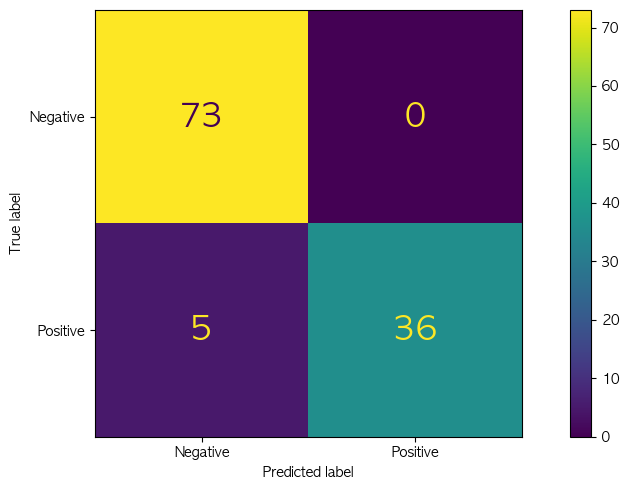

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


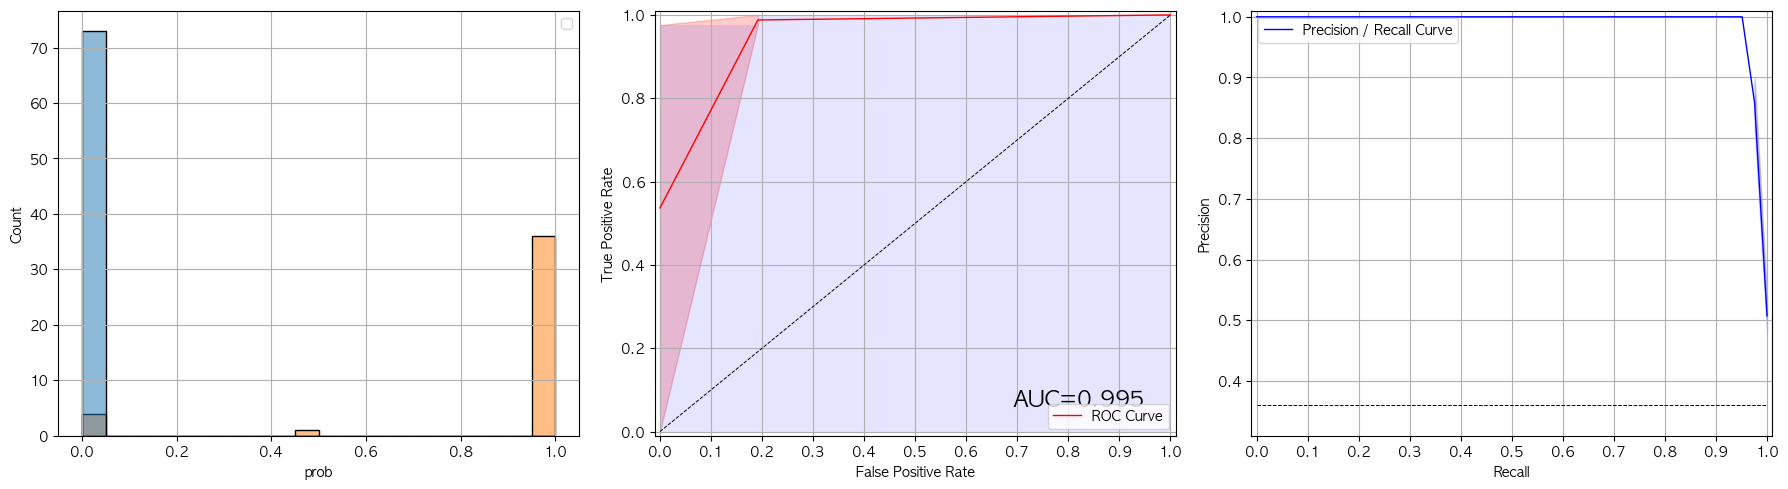


[학습곡선]


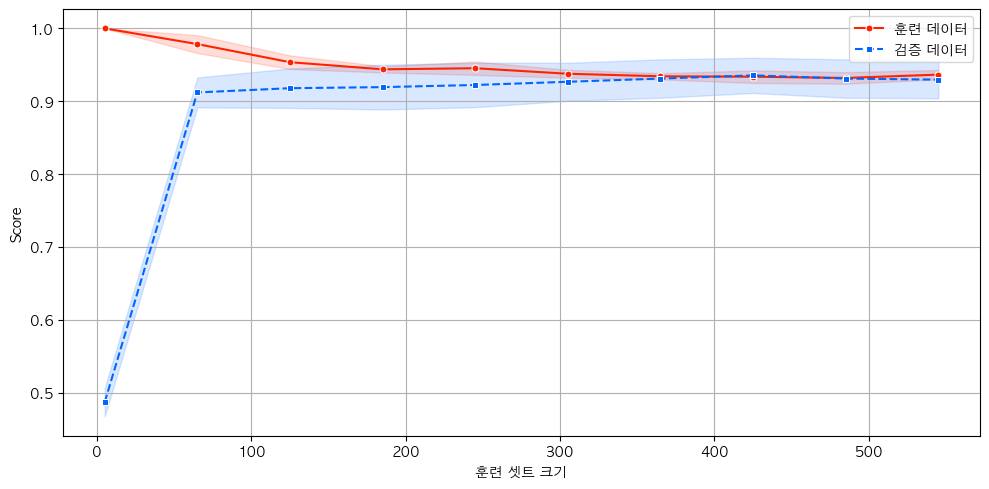

CPU times: user 1.98 s, sys: 804 ms, total: 2.78 s
Wall time: 573 ms


GaussianNB()

In [21]:
%%time
my_gnb_classification(xdata, ydata, x_test, y_test)

### [4] 전체 성능 비교

In [22]:
%%time
my_classification(xdata, ydata, x_test, y_test)

<class 'sklearn.svm._classes.SVC'>는 n_jobs를 허용하지 않음
<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
+----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                      |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB           |                         0 |            0.95614 |                   1 |         0.878049 |                   0 |             1 |   0.935065 | 0.995322 |
| KNeighborsClassifier |                         0 |           0.973684 |               0.975 |          0.95122 |           0.0136986 |      0.986301 |   0.962963 | 0.985633 |
| LogisticRegression   |   

## #03. 타이타닉 생존률 예측

### [1] 데이터 가져오기

In [31]:
origin = my_read_excel("https://data.hossam.kr/edadata/titanic.xlsx", index_col='PassengerId', categories=['Survived', 'Pclass', 'Sex', 'Embarked'], info=False)

### [2] 데이터 전처리

1. 생존 여부에 따른 평균 나이로 결측치 치환
2. 히스토그램 구간에 따라 나이를 명목형으로 변환
3. 객실 유무에 따른 명목형 변수 생성
4. 가족 구성원 수 파생변수 생성
5. 혼자 탑승했는지에 대한 파생변수 생성
6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
8. 이름으로부터 호칭 파생변수 생성
9. 데이터 라벨링
10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
11. 불필요한 컬럼 제거
12. 훈련/검증 데이터 분리

In [32]:
df = origin.copy()

# 1. 생존 여부에 따른 평균 나이로 결측치 치환
mean_age_df = df[['Survived','Age']].groupby('Survived').mean()

for i in mean_age_df.index:
    mean_age = round(mean_age_df.loc[i]['Age'], 0)
    expr = (df['Survived'] == i) & (df['Age'].isna())
    df.loc[expr, 'Age'] = df.loc[expr, 'Age'].fillna(mean_age)

# 2. 히스토그램 구간에 따라 나이를 명목형으로 변환
hist, bins = np.histogram(df['Age'], bins=5)

df2 = df.copy()
df2.loc[ df2['Age'] <= 16, "Age"] = 0
df2.loc[ (df2['Age'] > 16) & (df2['Age'] <= 32), "Age"] = 1
df2.loc[ (df2['Age'] > 32) & (df2['Age'] <= 48), "Age"] = 2
df2.loc[ (df2['Age'] > 48) & (df2['Age'] <= 64), "Age"] = 3
df2.loc[ df2['Age'] > 64, "Age"] = 4

# 3. 객실 유무에 따른 명목형 변수 생성
df2['Has_Cabin'] = df2['Cabin'].apply(lambda x:  0 if type(x) == float else 1)
df2['Has_Cabin'].value_counts()

# 4. 가족 구성원 수 파생변수 생성
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1

# 5. 혼자 탑승했는지에 대한 파생변수 생성
df2['IsAlone'] = 0
df2.loc[df2['FamilySize'] == 1, 'IsAlone'] = 1

# 6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
most_embarked_df = df2[['Survived','Embarked']].groupby('Survived').agg(Series.mode)

for i in most_embarked_df.index:
    most = most_embarked_df.loc[i]['Embarked']
    expr = (df2['Survived'] == i) & (df2['Embarked'].isna())
    df2.loc[expr, 'Embarked'] = df2.loc[expr, 'Embarked'].fillna(most)

# 7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
mean_fare_df = df2[['Survived','Fare']].groupby('Survived').mean()

for i in mean_fare_df.index:
    mean_fare = mean_fare_df.loc[i]['Fare']
    expr = (df2['Survived'] == i) & (df2['Fare'].isna())
    df2.loc[expr, 'Fare'] = df2.loc[expr, 'Fare'].fillna(mean_fare)

# 8. 이름으로부터 호칭 파생변수 생성
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    
    return ""

df2['Title'] = df2['Name'].apply(get_title)

df2['Title'] = df2['Title'].replace(['Rev', 'Dr', 
                'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 
                'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer', 'Dona'], "Rare")

# 9. 데이터 라벨링
df3 = my_labelling(df2, 'Title', 'Embarked', 'Sex')

# 10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
df3.loc[ df3['Fare'] <= 7.9, "Fare"] = 0
df3.loc[ (df2['Fare'] > 7.9) & (df3['Fare'] <= 14.5), "Fare"] = 1
df3.loc[ (df3['Fare'] > 14.5) & (df3['Fare'] <= 31.3), "Fare"] = 2
df3.loc[ df3['Fare'] > 31.3, "Fare"] = 3

# 11. 불필요한 컬럼 제거
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
df4 = df3.drop(drop_elements, axis = 1)

# 12. 훈련/검증 데이터 분리
df4['Survived'] = df4['Survived'].astype('int')
x_train, x_test, y_train, y_test = my_train_test_split(df4, yname='Survived')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1047, 9), (262, 9), (1047,), (262,))

### [3] 나이브베이즈 분류

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+-----------------+-------------------+
|    |   var_smoothing |   mean_test_score |
|----+-----------------+-------------------|
|  0 |           1e-09 |          0.815657 |
|  1 |           1e-08 |          0.815657 |
|  2 |           1e-07 |          0.815657 |
|  3 |           1e-06 |          0.815657 |
|  4 |           1e-05 |          0.815657 |
+----+-----------------+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.813754 |     0.816794 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.706612 |     0.694656 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재

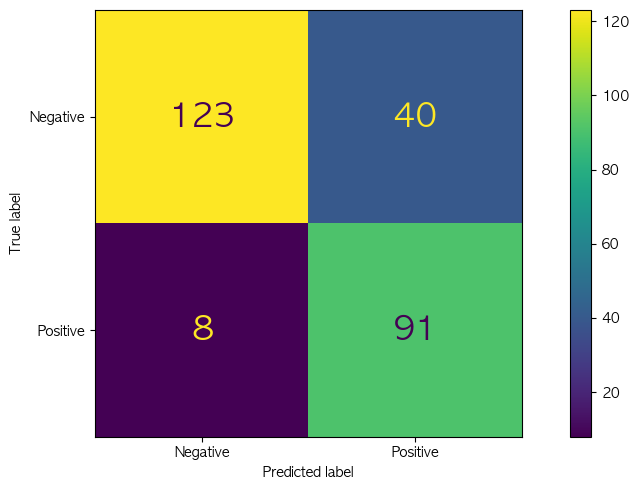

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


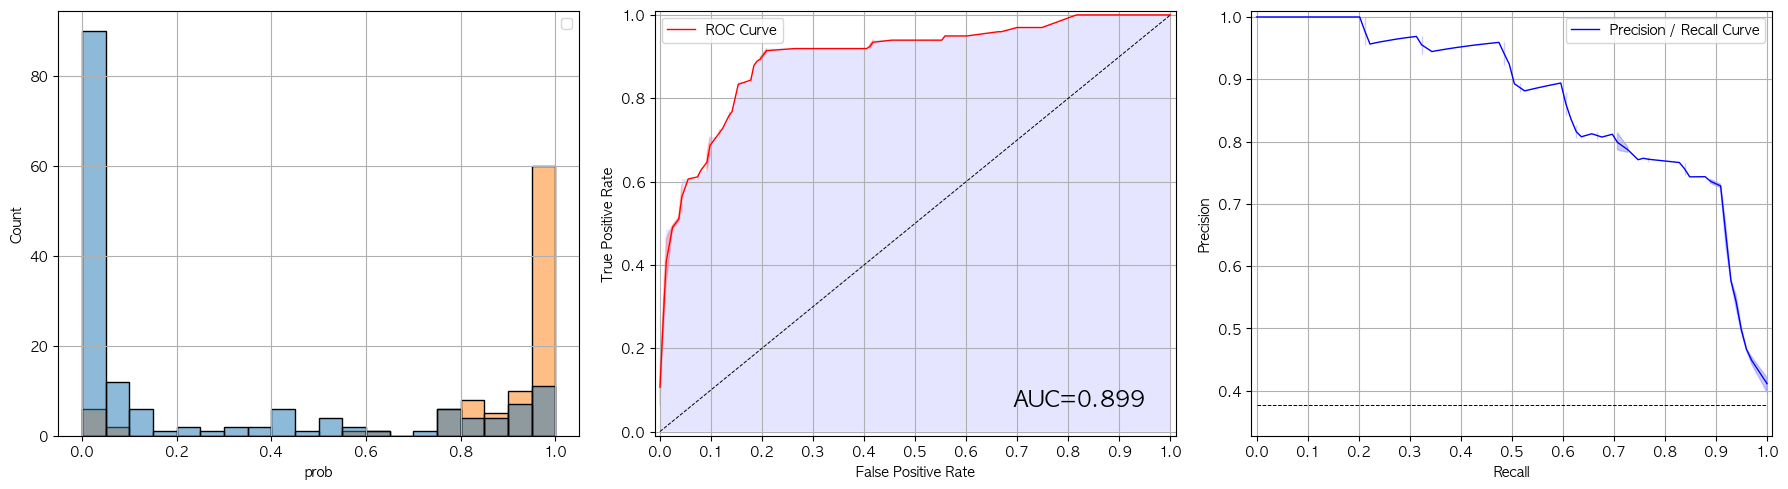

CPU times: user 1.59 s, sys: 27.5 ms, total: 1.62 s
Wall time: 598 ms


GaussianNB()

In [35]:
%%time
my_gnb_classification(x_train, y_train, x_test, y_test, learning_curve=False)

### [4] 전체 성능 비교

In [36]:
%%time
my_classification(x_train, y_train, x_test, y_test)

<class 'sklearn.svm._classes.SVC'>는 n_jobs를 허용하지 않음
<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
+----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                      |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB           |                         0 |           0.816794 |            0.694656 |         0.919192 |            0.245399 |      0.754601 |   0.791304 | 0.898866 |
| LogisticRegression   |                  0.479729 |           0.866412 |            0.826531 |         0.818182 |            0.104294 |      0.895706 |   0.822335 | 0.919998 |
| KNeighborsClassifier |   

## #04. 사과의 품질 분류

### [1] 데이터 가져오기

In [37]:
origin = my_read_excel("https://data.hossam.kr/mldata/apple_quality.xlsx", index_col='A_id', categories=['Quality'], info=False)

### [2] 데이터 전처리

1. 불필요한 행 제거
2. 종속변수 라벨링
3. 데이터 스케일링 + 훈련/검증 데이터 분리

In [38]:
df = origin.dropna()
df2 = my_labelling(df, 'Quality')
x_train, x_test, y_train, y_test = my_train_test_split(df2, yname='Quality', scalling=True)

### [3] 나이브베이즈 분류

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+-----------------+-------------------+
|    |   var_smoothing |   mean_test_score |
|----+-----------------+-------------------|
|  0 |           1e-09 |          0.751563 |
|  1 |           1e-08 |          0.751563 |
|  2 |           1e-07 |          0.751563 |
|  3 |           1e-06 |          0.751563 |
|  4 |           1e-05 |          0.751563 |
+----+-----------------+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.753125 |      0.71375 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |      0.75467 |     0.715762 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재

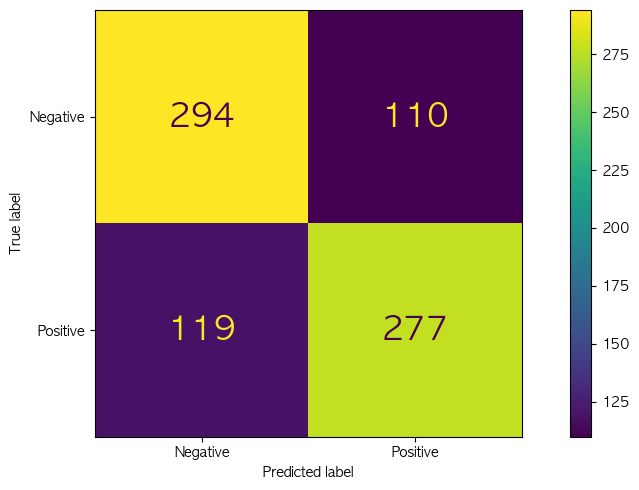

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


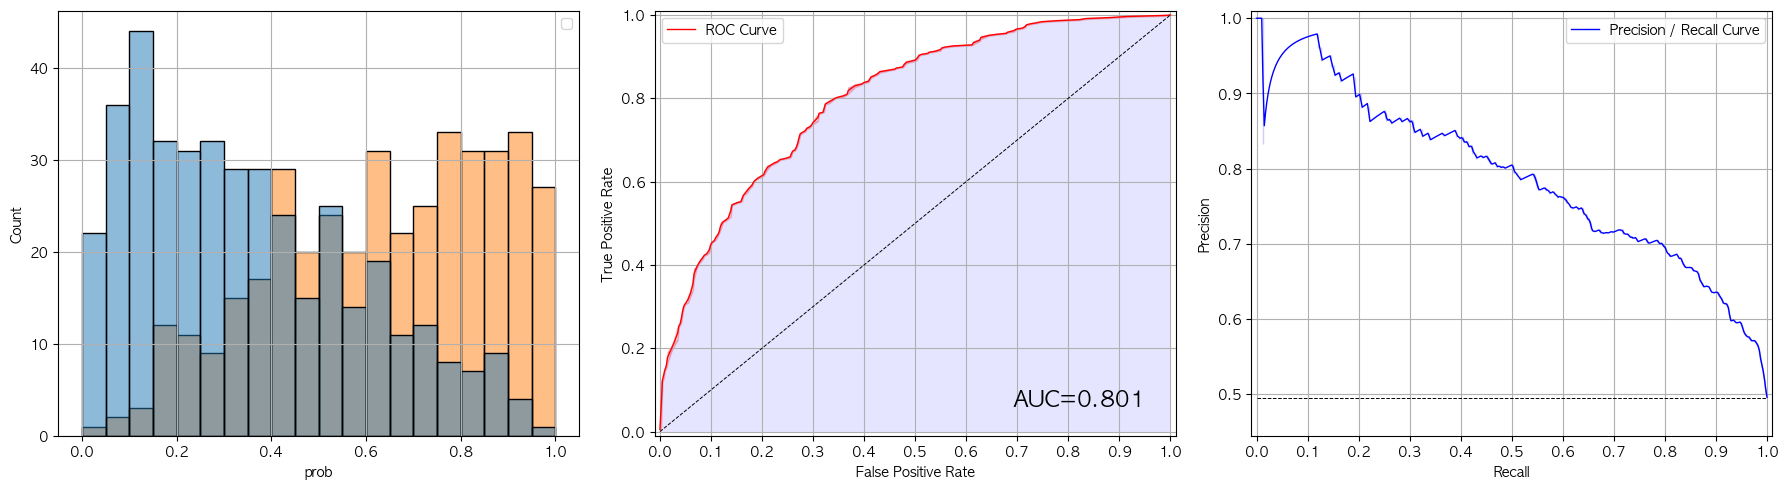


[학습곡선]


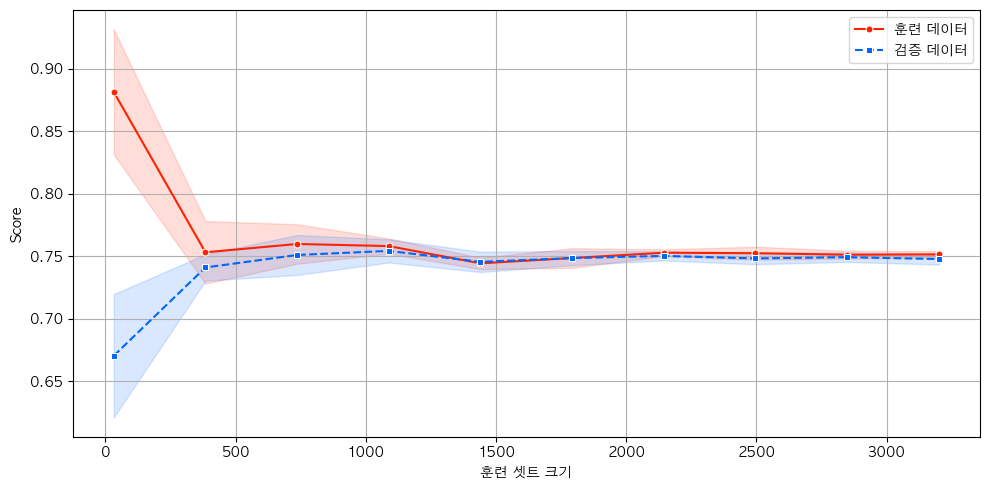

CPU times: user 3.31 s, sys: 27.2 ms, total: 3.34 s
Wall time: 2.06 s


GaussianNB()

In [39]:
%%time
my_gnb_classification(x_train, y_train, x_test, y_test)

### [4] 전체 성능 비교

In [41]:
%%time
my_classification(x_train, y_train, x_test, y_test)

<class 'sklearn.svm._classes.SVC'>는 n_jobs를 허용하지 않음
<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
+----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                      |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB           |                         0 |            0.71375 |            0.715762 |         0.699495 |            0.272277 |      0.727723 |   0.707535 | 0.801093 |
| LogisticRegression   |                  0.219192 |            0.73625 |            0.722892 |         0.757576 |            0.284653 |      0.715347 |   0.739827 | 0.807399 |
| KNeighborsClassifier |   